**Ecuación de Black - Scholes**

Abordaremos la resolución de la siguiente SDE correspondiente al modelo de Black - Scholes:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

Donde:

- $S_t$: Representa el valor de un activo (por ejemplo, una acción) en el tiempo \( t \).

- $\mu$: Es la tasa de crecimiento esperada del activo (también conocida como el "drift"), que refleja el comportamiento determinista de la acción.

- $\sigma$: Es la volatilidad del activo, que mide la incertidumbre o el "ruido" asociado con los cambios en el valor del activo.

- $dW_t$: Es el incremento del proceso de Wiener (también llamado movimiento browniano), que representa la parte aleatoria del cambio de $S_t$. Este proceso es fundamental para modelar la incertidumbre o la aleatoriedad en el precio del activo.



Para modelar el proceo de Weiner usamos el teorema de Kosambi–Karhunen–Loève:

$$
W_t = \sqrt{2} \sum_{k=1}^{\infty} \zeta_k \frac{\sin\left( \left(k - \frac{1}{2}\right) \pi t \right)}{(k - \frac{1}{2}) \pi}

$$

donde las $\zeta_k$ son variables aleatorias i.i.d. normales $N(0,1)$.

Hacemos la aproximación:

$$
W_t \thickapprox  \sqrt{2} \sum_{k=1}^{n} \zeta_k \frac{\sin\left( \left(k - \frac{1}{2}\right) \pi t \right)}{(k - \frac{1}{2}) \pi}
$$



Trabajaremos con la siguiente función de pérdida:

$$
\mathcal{L}(u,f)=\sum_t \left\| \frac{\partial u}{\partial t} - f(u,t) - g(u,t) \frac{\partial W(t, \zeta_1, \dots, \zeta_n)}{\partial t} \right\|
$$

Donde a partir de la aproximación para $W_t$ obtenemos:

$$
\frac{\partial W(t, \zeta_1, \dots, \zeta_n)}{\partial t} = \sqrt{2} \sum_{k=1}^{n} \zeta_k \cos \left( \left( k - \frac{1}{2} \right) \pi t \right)
$$



In [36]:
import math
from time import perf_counter as timer

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo


# Pandas
import pandas as pd


from tqdm import tqdm
 

# Semilla aleatoria
seed = 42

# Fijamos la semilla para Pytorch y Numpy
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     

In [37]:
def dWdt_kl_torch(t, zetas, T):

    N, n_terms = zetas.shape
    device = t.device
    dtype  = t.dtype

    k = torch.arange(1, n_terms + 1, device=device, dtype=dtype).view(1, -1) 

    t_hat = t / T                         
    arg = (k - 0.5) * math.pi * t_hat     
    cos_term = torch.cos(arg)             

    sum_term = (zetas * cos_term).sum(dim=1, keepdim=True)  

    factor = math.sqrt(2.0 / float(T))
    return factor * sum_term             


In [38]:
class LogSPINN(nn.Module):
    def __init__(self, T, n_terms, hidden_dim=64, n_hidden=3):
        super().__init__()
        self.T  = T
        self.n_terms = n_terms

        in_dim = 1 + n_terms  
        out_dim = 1           

        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(n_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, zetas):
        t_norm = t / self.T
        x = torch.cat([t_norm, zetas], dim=1)
        u_theta = self.net(x) 
        return u_theta


In [39]:
def residual_pde_logS(model, t, zetas, mu, sigma, T):
    t_req = t.clone().detach().requires_grad_(True)
    z_req = zetas.clone().detach()

    u_pred = model(t_req, z_req) 

    du_dt = torch.autograd.grad(
        u_pred,
        t_req,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]

    dWdt = dWdt_kl_torch(t_req, z_req, T)  

    rhs = (mu - 0.5 * sigma**2) + sigma * dWdt
    
    res = du_dt - rhs
    return res, u_pred, t_req

In [40]:
def pinn_loss_logS(model, mu, sigma, T, n_terms,
                   N_colloc=1024, N_ic=128, device="cpu"):

    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res, u_pred, _ = residual_pde_logS(model, t_colloc, z_colloc, mu, sigma, T)
    loss_pde = torch.mean(res**2)

    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)

    u0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean(u0_pred**2)

    return loss_pde + loss_ic, loss_pde.detach(), loss_ic.detach()


In [41]:
S0_val   = 100.0
mu_val   = 0.05
sigma_val= 0.2
T_val    = 1.0
n_terms  = 20

mu_t    = torch.tensor(mu_val,    dtype=torch.float32, device=device)
sigma_t = torch.tensor(sigma_val, dtype=torch.float32, device=device)
T_t     = torch.tensor(T_val,     dtype=torch.float32, device=device)
S0_t    = torch.tensor(S0_val,    dtype=torch.float32, device=device)

model = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss, loss_pde, loss_ic = pinn_loss_logS(
        model,
        mu_t, sigma_t, T_t,
        n_terms,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | total={loss.item():.4e} | pde={loss_pde.item():.4e} | ic={loss_ic.item():.4e}")


Epoch   500 | total=6.0448e-01 | pde=6.0243e-01 | ic=2.0427e-03
Epoch  1000 | total=4.5147e-01 | pde=4.4998e-01 | ic=1.4944e-03
Epoch  1500 | total=2.9817e-01 | pde=2.9779e-01 | ic=3.8511e-04
Epoch  2000 | total=1.8265e-01 | pde=1.8228e-01 | ic=3.7037e-04
Epoch  2500 | total=1.2616e-01 | pde=1.2598e-01 | ic=1.7521e-04
Epoch  3000 | total=1.0657e-01 | pde=1.0646e-01 | ic=1.1440e-04
Epoch  3500 | total=6.3440e-02 | pde=6.3278e-02 | ic=1.6139e-04
Epoch  4000 | total=5.6150e-02 | pde=5.5899e-02 | ic=2.5109e-04
Epoch  4500 | total=3.2266e-02 | pde=3.2077e-02 | ic=1.8980e-04
Epoch  5000 | total=2.9547e-02 | pde=2.9351e-02 | ic=1.9553e-04


In [42]:
import math
import torch

def W_kl_torch(t, zetas, T):
    N, n_terms = zetas.shape
    device = t.device
    dtype  = t.dtype

    k = torch.arange(1, n_terms + 1, device=device, dtype=dtype).view(1, -1) 

    t_hat = t / T                        
    arg = (k - 0.5) * math.pi * t_hat  
    sin_term = torch.sin(arg)          


    coeff = math.sqrt(2.0 * float(T)) / ((k - 0.5) * math.pi)  


    W = (zetas * coeff * sin_term).sum(dim=1, keepdim=True)  
    return W


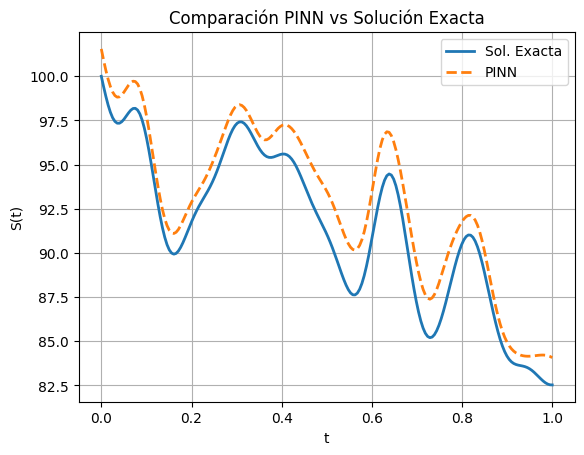

Max |S_pinn - S_exact|: 2.7384262


In [43]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

n_t = 200
t_plot = torch.linspace(0, T_val, n_t, device=device).view(-1, 1)  


z_single = torch.randn(1, n_terms, device=device)  
z = z_single.repeat(n_t, 1)                       



with torch.no_grad():
    u_pinn = model(t_plot, z)         
    S_pinn = S0_t * torch.exp(u_pinn) 


W = W_kl_torch(t_plot, z, T_t)     


u_exact = (mu_t - 0.5 * sigma_t**2) * t_plot + sigma_t * W 

S_exact = S0_t * torch.exp(u_exact)

t_np       = t_plot.cpu().numpy().ravel()
S_pinn_np = S_pinn.cpu().numpy().ravel()
S_exact_np = S_exact.cpu().numpy().ravel()

plt.figure()
plt.plot(t_np, S_exact_np, label="Sol. Exacta", linewidth=2)
plt.plot(t_np, S_pinn_np, "--", label="PINN", linewidth=2)
plt.xlabel("t")
plt.ylabel("S(t)")
plt.title("Comparación PINN vs Solución Exacta")
plt.legend()
plt.grid(True)
plt.show()

abs_diff = np.abs(S_pinn_np - S_exact_np)
print("Max |S_pinn - S_exact|:", abs_diff.max())

**Ahora adaptamos el código para entrenar con datos:**

In [44]:
class BlackScholesKL:

    def __init__(self, S0, mu, sigma, T, n_terms=20):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.n_terms = n_terms
        self.zetas = np.random.normal(0, 1, size=self.n_terms).astype(np.float32)

    def W_kl(self, t):

        t = np.array(t, ndmin=1)
        t_hat = t / self.T

        k = np.arange(1, self.n_terms + 1)
        numer = np.sin((k - 0.5) * np.pi * t_hat[:, None])
        denom = (k - 0.5) * np.pi

        W = np.sqrt(2 * self.T) * np.sum(self.zetas[None, :] * numer / denom, axis=1)
        return W

    def dWdt_kl(self, t):
        t = np.array(t, ndmin=1)
        t_hat = t / self.T

        k = np.arange(1, self.n_terms + 1)
        arg = (k - 0.5) * np.pi * t_hat[:, None]

        dWdt = np.sqrt(2.0 / self.T) * np.sum(self.zetas[None, :] * np.cos(arg), axis=1)
        return dWdt

    def simulate_path(self, N=200):
        t = np.linspace(0, self.T, N)
        dt = t[1] - t[0]

        W = self.W_kl(t)
        dW = np.diff(W)

        S = np.zeros(N)
        S[0] = self.S0

        for i in range(N - 1):
            dS = self.mu * S[i] * dt + self.sigma * S[i] * dW[i]
            S[i + 1] = S[i] + dS

        dWdt = self.dWdt_kl(t)

        return t, S, dWdt
    def generate_dataset(self, N=200):
        t = np.linspace(0, self.T, N)
        W = self.W_kl(t)
        dWdt = self.dWdt_kl(t)

        _, S, _ = self.simulate_path(N)

        return {
            "t": t,
            "S": S,
            "W": W,
            "dWdt": dWdt,
            "zetas": self.zetas
        }


In [45]:
def generate_logS_data_from_KL(S0, mu, sigma, T, n_terms, N_time=200, N_paths=10):
    all_t = []
    all_z = []
    all_u = []

    for _ in range(N_paths):
        sim = BlackScholesKL(S0, mu, sigma, T, n_terms=n_terms)
        data = sim.generate_dataset(N=N_time)

        t = data["t"]              
        S = data["S"]              
        zetas = data["zetas"]     

        u = np.log(S / S0)

        z_path = np.tile(zetas, (N_time, 1))

        all_t.append(t.reshape(-1, 1))
        all_z.append(z_path)
        all_u.append(u.reshape(-1, 1))

    t_data = np.vstack(all_t)   
    z_data = np.vstack(all_z)  
    u_data = np.vstack(all_u)  

    return t_data, z_data, u_data


In [46]:
t_data_np, z_data_np, u_data_np = generate_logS_data_from_KL(
    S0_val, mu_val, sigma_val, T_val,
    n_terms=n_terms,
    N_time=200,
    N_paths=20
)

In [47]:
def pinn_loss_logS_with_data(model, mu, sigma, T, n_terms,
                             t_data=None, z_data=None, u_data=None,
                             lambda_data=1.0,
                             N_colloc=1024, N_ic=128, device="cpu"):

    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res, u_pred, _ = residual_pde_logS(model, t_colloc, z_colloc, mu, sigma, T)
    loss_pde = torch.mean(res**2)

    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)

    u0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean(u0_pred**2)


    loss_data = torch.tensor(0.0, device=device)

    if t_data is not None and z_data is not None and u_data is not None:

        u_data_pred = model(t_data, z_data)
        loss_data = torch.mean((u_data_pred - u_data)**2)

    loss_total = loss_pde + loss_ic + lambda_data * loss_data


    return (loss_total,
            loss_pde.detach(),
            loss_ic.detach(),
            loss_data.detach())


In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

S0_val   = 100.0
mu_val   = 0.05
sigma_val= 0.2
T_val    = 1.0
n_terms  = 20

t_data = torch.tensor(t_data_np, dtype=torch.float32, device=device)
z_data = torch.tensor(z_data_np, dtype=torch.float32, device=device)
u_data = torch.tensor(u_data_np, dtype=torch.float32, device=device)

model = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000
lambda_data = 1.0 

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss, loss_pde, loss_ic, loss_data = pinn_loss_logS_with_data(
        model,
        mu_t, sigma_t, T_t,
        n_terms,
        t_data=t_data,    
        z_data=z_data,
        u_data=u_data,
        lambda_data=lambda_data,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Epoch {epoch:5d} | "
            f"total={loss.item():.4e} | "
            f"pde={loss_pde.item():.4e} | "
            f"ic={loss_ic.item():.4e} | "
            f"data={loss_data.item():.4e}"
        )


Epoch   500 | total=6.5523e-01 | pde=6.5074e-01 | ic=2.4191e-03 | data=2.0665e-03
Epoch  1000 | total=4.6349e-01 | pde=4.6135e-01 | ic=5.7651e-04 | data=1.5714e-03
Epoch  1500 | total=3.0980e-01 | pde=3.0741e-01 | ic=7.8064e-04 | data=1.6097e-03
Epoch  2000 | total=2.5860e-01 | pde=2.5365e-01 | ic=3.9976e-03 | data=9.4593e-04
Epoch  2500 | total=1.6613e-01 | pde=1.6357e-01 | ic=1.3968e-03 | data=1.1597e-03
Epoch  3000 | total=1.0844e-01 | pde=1.0743e-01 | ic=5.6141e-04 | data=4.4986e-04
Epoch  3500 | total=6.5733e-02 | pde=6.4486e-02 | ic=5.4253e-04 | data=7.0401e-04
Epoch  4000 | total=4.5500e-02 | pde=4.5093e-02 | ic=1.4798e-04 | data=2.5880e-04
Epoch  4500 | total=4.7867e-02 | pde=4.7383e-02 | ic=1.9652e-04 | data=2.8761e-04
Epoch  5000 | total=2.8249e-02 | pde=2.7673e-02 | ic=2.8812e-04 | data=2.8765e-04


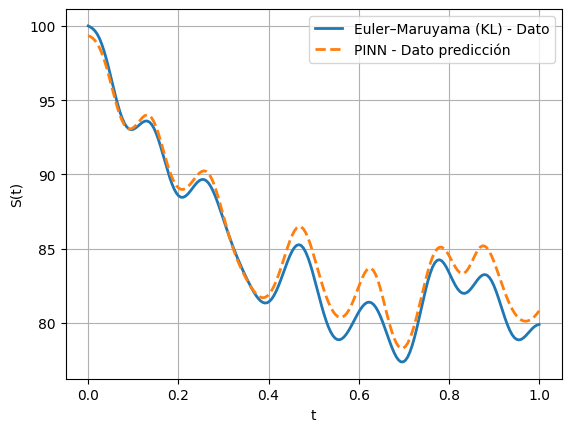

In [49]:

sim_test = BlackScholesKL(S0_val, mu_val, sigma_val, T_val, n_terms=n_terms)
data_test_path = sim_test.generate_dataset(N=200)

t_np_path = data_test_path["t"]           
S_np_path = data_test_path["S"]           
zetas_np  = data_test_path["zetas"]       


t_path = torch.tensor(t_np_path, dtype=torch.float32, device=device).view(-1, 1)
z_path = torch.tensor(
    np.tile(zetas_np, (t_np_path.shape[0], 1)),
    dtype=torch.float32,
    device=device
)

with torch.no_grad():
    u_pinn_path = model(t_path, z_path)         
    S_pinn_path = S0_t * torch.exp(u_pinn_path) 


S_pinn_np = S_pinn_path.cpu().numpy().ravel()


plt.figure()
plt.plot(t_np_path, S_np_path, label="Euler–Maruyama (KL) - Dato", linewidth=2)
plt.plot(t_np_path, S_pinn_np, "--", label="PINN - Dato predicción", linewidth=2)
plt.legend()
plt.xlabel("t")
plt.ylabel("S(t)")
plt.grid(True)
plt.show()


Ahora realizamos una comparación entre PINN física y PINN física más datos

In [50]:
S0_val   = 100.0
mu_val   = 0.05
sigma_val= 0.2
T_val    = 1.0
n_terms  = 20


N_time   = 200     
N_paths_total = 40 

t_all_np, z_all_np, u_all_np = generate_logS_data_from_KL(
    S0_val, mu_val, sigma_val, T_val,
    n_terms=n_terms,
    N_time=N_time,
    N_paths=N_paths_total
)

N_total = t_all_np.shape[0]
idx = np.random.permutation(N_total)
split = int(0.8 * N_total)

idx_train = idx[:split]
idx_test  = idx[split:]

t_train_np = t_all_np[idx_train]
z_train_np = z_all_np[idx_train]
u_train_np = u_all_np[idx_train]

t_test_np  = t_all_np[idx_test]
z_test_np  = z_all_np[idx_test]
u_test_np  = u_all_np[idx_test]


device = "cuda" if torch.cuda.is_available() else "cpu"

t_train = torch.tensor(t_train_np, dtype=torch.float32, device=device)
z_train = torch.tensor(z_train_np, dtype=torch.float32, device=device)
u_train = torch.tensor(u_train_np, dtype=torch.float32, device=device)

t_test  = torch.tensor(t_test_np,  dtype=torch.float32, device=device)
z_test  = torch.tensor(z_test_np,  dtype=torch.float32, device=device)
u_test  = torch.tensor(u_test_np,  dtype=torch.float32, device=device)


In [51]:

model_phys = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
opt_phys = torch.optim.Adam(model_phys.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    opt_phys.zero_grad()
    loss, loss_pde, loss_ic = pinn_loss_logS(
        model_phys,
        mu_t, sigma_t, T_t,
        n_terms,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    opt_phys.step()

    if epoch % 500 == 0:
        print(f"[PHYS] Epoch {epoch} | total={loss:.3e}")


[PHYS] Epoch 500 | total=6.530e-01
[PHYS] Epoch 1000 | total=5.516e-01
[PHYS] Epoch 1500 | total=3.697e-01
[PHYS] Epoch 2000 | total=2.883e-01
[PHYS] Epoch 2500 | total=2.079e-01
[PHYS] Epoch 3000 | total=1.784e-01
[PHYS] Epoch 3500 | total=1.399e-01
[PHYS] Epoch 4000 | total=9.911e-02
[PHYS] Epoch 4500 | total=9.066e-02
[PHYS] Epoch 5000 | total=6.013e-02


In [52]:
model_data = LogSPINN(T_t, n_terms, hidden_dim=128, n_hidden=5).to(device)
opt_data = torch.optim.Adam(model_data.parameters(), lr=1e-3)

lambda_data = 1.0

for epoch in range(1, n_epochs + 1):
    opt_data.zero_grad()
    loss, loss_pde, loss_ic, loss_data = pinn_loss_logS_with_data(
        model_data,
        mu_t, sigma_t, T_t,
        n_terms,
        t_data=t_train,
        z_data=z_train,
        u_data=u_train,
        lambda_data=lambda_data,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    opt_data.step()

    if epoch % 500 == 0:
        print(f"[DATA] Epoch {epoch} | total={loss:.3e} | data={loss_data:.3e}")


[DATA] Epoch 500 | total=6.538e-01 | data=1.104e-03
[DATA] Epoch 1000 | total=3.956e-01 | data=6.420e-04
[DATA] Epoch 1500 | total=2.418e-01 | data=1.178e-03
[DATA] Epoch 2000 | total=9.806e-02 | data=7.765e-04
[DATA] Epoch 2500 | total=3.627e-02 | data=1.263e-04
[DATA] Epoch 3000 | total=3.209e-02 | data=3.831e-04
[DATA] Epoch 3500 | total=2.139e-02 | data=2.037e-04
[DATA] Epoch 4000 | total=1.362e-02 | data=1.415e-04
[DATA] Epoch 4500 | total=1.531e-02 | data=1.038e-04
[DATA] Epoch 5000 | total=2.131e-02 | data=1.571e-04


In [58]:
def evaluate_model(model, t_test, z_test, u_test, S0_t):
    model.eval()
    with torch.no_grad():
        u_pred = model(t_test, z_test)
        S_pred = S0_t * torch.exp(u_pred)
        S_true = S0_t * torch.exp(u_test)

        mse_u  = torch.mean((u_pred - u_test)**2).item()
        mae_u  = torch.mean(torch.abs(u_pred - u_test)).item()
        rel_S  = torch.mean(torch.abs(S_pred - S_true) / (S_true + 1e-8)).item()

    return mse_u, mae_u, rel_S


In [59]:
mse_u_phys, mae_u_phys, rel_S_phys = evaluate_model(
    model_phys, t_test, z_test, u_test, S0_t
)

mse_u_data, mae_u_data, rel_S_data = evaluate_model(
    model_data, t_test, z_test, u_test, S0_t
)

print("=== RESULTADOS EN TEST ===")
print(f"Física pura:  MSE_u={mse_u_phys:.3e} | MAE_u={mae_u_phys:.3e} | RelErr_S={rel_S_phys:.3e}")
print(f"Con datos:    MSE_u={mse_u_data:.3e} | MAE_u={mae_u_data:.3e} | RelErr_S={rel_S_data:.3e}")


=== RESULTADOS EN TEST ===
Física pura:  MSE_u=3.889e-04 | MAE_u=1.468e-02 | RelErr_S=1.454e-02
Con datos:    MSE_u=1.632e-04 | MAE_u=1.116e-02 | RelErr_S=1.115e-02


In [60]:
sim_new = BlackScholesKL(S0_val, mu_val, sigma_val, T_val, n_terms=n_terms)
data_new = sim_new.generate_dataset(N=200)

t_new_np = data_new["t"]
S_new_np = data_new["S"]
z_new_np = np.tile(data_new["zetas"], (len(t_new_np), 1))

t_new = torch.tensor(t_new_np, dtype=torch.float32, device=device).view(-1,1)
z_new = torch.tensor(z_new_np, dtype=torch.float32, device=device)


In [61]:
with torch.no_grad():
    u_phys = model_phys(t_new, z_new)
    u_data = model_data(t_new, z_new)

S_phys = S0_t * torch.exp(u_phys)
S_data = S0_t * torch.exp(u_data)


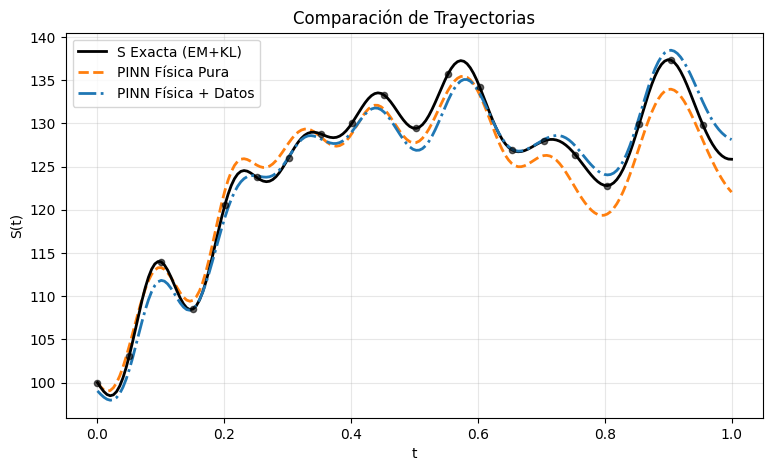

In [64]:
plt.figure(figsize=(9,5))
plt.plot(t_new_np, S_new_np, label="S Exacta (EM+KL)",
         color='black', linewidth=2, zorder=3)
plt.plot(t_new_np, S_phys.cpu().numpy().ravel(), "--",
         label="PINN Física Pura", color='tab:orange', linewidth=2, zorder=2)
plt.plot(t_new_np, S_data.cpu().numpy().ravel(), "-.",
         label="PINN Física + Datos", color='tab:blue', linewidth=2, zorder=4)
plt.scatter(t_new_np[::10], S_new_np[::10], color='black', s=20, alpha=0.6, zorder=5)

plt.title("Comparación de Trayectorias")
plt.xlabel("t")
plt.ylabel("S(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
